# Logistic Regression with a Neural Network

İlk olarak ihtiyacınız olacak tüm paketleri içe aktarmak için aşağıdaki hücreyi çalıştıralım.

   * numpy, Python ile bilimsel hesaplama için temel pakettir.
   * h5py, H5 dosyasında depolanan bir veri kümesiyle etkileşim kurmak için kullanılan yaygın bir pakettir.
   * matplotlib, Python'da grafikler çizmek için ünlü bir kütüphanedir.
   * PIL ve scipy, modelinizi sonunda kendi resminizle test etmek için burada kullanılır.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset

%matplotlib inline

## 1-) Eğitim kümesine genel bakış

Bir veri kümesi ("data.h5") verilir: - kedi (y = 1) veya kedi olmayan (y = 0) olarak etiketlenmiş eğitim seti. (num_px, num_px, 3). Bu nedenle, her görüntü kare (yükseklik = num_px) ve (genişlik = num_px) olur.

Resimleri kedi veya kedi olmayan olarak doğru bir şekilde sınıflandırabilen basit bir görüntü tanıma algoritması oluşturacaksınız.

Veri kümesini daha yakından tanıyalım. Aşağıdaki kodu çalıştırarak verileri yükleyin.

In [5]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Görüntü veri kümelerinin sonuna (train ve test) "_orig" ekledik çünkü bunları ön işleme tabi tutacağız. Önişlemeden sonra train_set_x ve test_set_x (train_set_y ve test_set_y etiketleri için herhangi bir ön işleme gerek yoktur) elde edeceğiz.

Train_set_x_orig ve test_set_x_orig öğelerinizin her satırı, bir resmi temsil eden bir dizidir. Aşağıdaki kodu çalıştırarak bir örneği görselleştirebilirsiniz. Ayrıca indeks değerini değiştirmekten çekinmeyin ve diğer görüntüleri görmek için tekrar çalıştırın.

y = [0], it's a 'non-cat' picture.


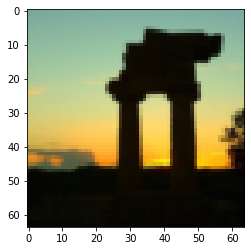

In [8]:
index = 40
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Derin öğrenmedeki birçok yazılım hatası, uymayan matris / vektör boyutlarına sahip olmaktan gelir. Matris / vektör boyutlarınızı düz tutabiliyorsanız, birçok hatayı ortadan kaldırmak için uzun bir yol kat edeceksiniz.

Alıştırma: Şunun için değerleri bulun: - m_train (egzersiz örneği sayısı) - m_test (test örneği sayısı) - num_px (= yükseklik = bir egzersiz görüntüsünün genişliği) train_set_x_orig öğesinin sayısal bir dizi olduğunu unutmayın (m_train, num_px, sayı_px, 3). Örneğin, m_train'e train_set_x_orig.shape [0] yazarak erişebilirsiniz.

In [9]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


Kolaylık sağlamak için şimdi şekil görüntülerini (num_px, num_px, 3) 'den bir dizi şekil dizisine dönüştürelim
(num_px ∗ num_px ∗ 3, 1). Bundan sonra, eğitim (ve test) veri setimiz, her sütunun düzleştirilmiş bir görüntüyü temsil ettiği bir numpy dizisidir. M_train (sırasıyla m_test) sütunları olmalıdır.

In [10]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


Renkli görüntüleri temsil etmek için, her piksel için kırmızı, yeşil ve mavi kanallar (RGB) belirtilmelidir ve bu nedenle piksel değeri aslında 0 ila 255 arasında değişen üç sayıdan oluşan bir vektördür.

Makine öğreniminde yaygın olarak kullanılan bir önişleme adımı, veri kümenizi ortalamak ve standartlaştırmaktır, yani her bir örnekten tüm numpy dizisinin ortalamasını özetlersiniz ve daha sonra her örneği tüm numpy dizisinin standart sapmasına bölersiniz. Ancak resim veri kümeleri için, daha basit ve daha kullanışlıdır ve veri kümesinin her satırını 255'e (bir piksel kanalının maksimum değeri) bölmek neredeyse iyi çalışır.

Veri setimizi standartlaştıralım.

In [11]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# 2-) Öğrenme algoritmasının Genel Mimarisi

Kedi görüntülerini kedi olmayan görüntülerden ayırt etmek için basit bir algoritma tasarlamanın zamanı geldi.

Sinir Ağı zihniyetini kullanarak bir Lojistik Regresyon oluşturacaksınız. Aşağıdaki şekilde Lojistik Regresyonun neden gerçekten çok basit bir Sinir Ağı olduğu açıklanmaktadır!

#### Algoritmanın matematiksel ifadesi:

Bir örnek için $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Daha sonra maliyet, tüm eğitim örnekleri üzerinde toplanarak hesaplanır:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

# 3-) Algoritmamızın parçalarını oluşturalım

Bir Sinir Ağı oluşturmanın ana adımları şunlardır:

   1. Model yapısını tanımlayın (giriş özelliklerinin sayısı gibi)
   2. Modelin parametrelerini başlat
   3. Döngü:
       * Akım kaybını hesapla (ileri yayılma)
       * Geçerli gradyanı hesapla (geriye doğru yayılma)
       * Parametreleri güncelleme (gradyan inişi)

Genellikle 1-3'ü ayrı ayrı oluşturursunuz ve bunları model () dediğimiz bir işleve entegre edersiniz.

### 3.1 - Yardımcı Fonksiyonlar

**Exercise**: "Python Basics" kodunuzu kullanma, uygula `sigmoid()`. Yukarıdaki şekilde gördüğünüz gibi, hesaplamanız gerekiyor $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ tahminlerde bulunmak. kullanım np.exp().

In [16]:
# aktivsyon fonksiyonumuz

def sigmoid(z):
   
    s = 1 / (1 + np.exp(-z))

    return s

In [17]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 3.2 - Parametreleri başlatma

Alıştırma: Aşağıdaki hücreye parametre başlatma uygulayın. W'yi sıfırlar vektörü olarak başlatmalısınız. Hangi numpy işlevini kullanacağınızı bilmiyorsanız, Numpy kütüphanesinin belgelerinde np.zeros () konusuna bakın.

In [18]:
def initialize_with_zeros(dim):
    
    w = np.zeros(shape=(dim, 1)) # ağırlıklar
    b = 0 # bias

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [19]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 3.3 - İleri ve Geri Yayılım

Parametreleriniz başlatıldığına göre, parametreleri öğrenmek için "ileri" ve "geri" yayma adımlarını yapabilirsiniz.

Alıştırma: Maliyet fonksiyonunu ve degradesini hesaplayan bir işlev propagate () uygulayın.

İpuçları:

İleri Yayılım:

- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [20]:
def propagate(w, b, X, Y):
    """
    w -- ağırlıklar, numpy boyut dizisi (num_px * num_px * 3, 1)
    b -- bias, real sayı
    X -- boyut verileri (num_px * num_px * 3, örnek sayısı)
    Y -- gerçek "etiket" vektörü (kedi değilse 0, kedi ise 1 içerir) (1, örnek sayısı)

    Return:
    maliyet - lojistik regresyon için negatif log olabilirlik maliyeti
    dw - kaybın w'ye göre gradyanı, böylece w ile aynı şekil
    db - b'ye göre kaybın gradyanı, b ile aynı şekilde
    """
    
    m = X.shape[1] # eğitim örnek sayısı
    

    A = sigmoid(np.dot(w.T, X) + b)  # aktivasyon fonksiyonu
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # maliyet fonksiyonu

    
    dw = (1 / m) * np.dot(X, (A - Y).T) # ağırlıkların türevi
    db = (1 / m) * np.sum(A - Y) # bias ın türevi
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [21]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 3.4 - Optimizasyon

   * Parametrelerinizi başlattınız.
   * Ayrıca bir maliyet fonksiyonunu ve degradesini de hesaplayabilirsiniz.
   * Şimdi, degrade iniş kullanarak parametreleri güncellemek istiyorsunuz.
   
**Exercise:** Optimizasyon işlevini yazın. Amaç öğrenmektir $w$ ve $b$ maliyet fonksiyonunu en aza indirerek $J$. Parametre için $\theta$, güncelleme kuralı $ \theta = \theta - \alpha \text{ } d\theta$, $\alpha$ öğrenme oranıdır.

In [22]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Bu işlev, bir degrade iniş algoritması çalıştırarak w ve b'yi en iyi duruma getirir.
    
    Argümanlar:
    w - ağırlıklar, numpy boyut dizisi (num_px * num_px * 3, 1)
    b - önyargı, bir skaler
    X - şekil verileri (num_px * num_px * 3, örnek sayısı)
    Y - gerçek "etiket" vektörü (kedi değilse 0, kedi ise 1 içerir), şekil (1, örnek sayısı)
    num_iterations - optimizasyon döngüsünün yineleme sayısı
    learning_rate - degrade iniş güncelleme kuralının öğrenme oranı
    print_cost - Kaybı her 100 adımda bir yazdırmak için doğru
    
    İadeler:
    params - w ve bias ağırlıklarını içeren sözlük
    grad - maliyet fonksiyonuna göre ağırlık ve sapma gradyanlarını içeren sözlük
    maliyetler - optimizasyon sırasında hesaplanan tüm maliyetlerin listesi, bu öğrenme eğrisini çizmek için kullanılacaktır.
    
    İpuçları:
    Temel olarak iki adım yazmanız ve bunları tekrarlamanız gerekir:
        1) Geçerli parametreler için maliyeti ve degradeyi hesaplayın. Propagate () kullanın.
        2) w ve b için degrade iniş kuralını kullanarak parametreleri güncelleyin.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw # güncelleme
        b = b - learning_rate * db
  
        if i % 100 == 0:
            costs.append(cost)
        
        # Her 100 eğitim tekrarında maliyeti yazdırın
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [23]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Alıştırma: Önceki fonksiyon öğrenilen w ve b çıktısını verecektir. Veri kümesi X için etiketleri tahmin etmek için w ve b'yi kullanabiliriz. predict() işlevini uygulayın. Tahminleri hesaplamak için iki adım vardır:

1. Hesapla $\hat{Y} = A = \sigma(w^T X + b)$

2. A girişleri 0 (if activation <= 0.5) veya 1 (if activation > 0.5), tahminleri bir vektörde saklar `Y_prediction`. İsterseniz, bir `if`/`else` bir ifadede `for` döngü (içinden de bunu vektörleştirmenin bir yolu vardır).

In [25]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    """
    Öğrenilen lojistik regresyon parametrelerini (w, b) kullanarak etiketin 0 veya 1 olup olmadığını tahmin edin
    
    Argümanlar:
    w - ağırlıklar, numpy boyut dizisi (num_px * num_px * 3, 1)
    b - önyargı, bir skaler
    X - boyut verileri (num_px * num_px * 3, örnek sayısı)
    
    İadeler:
    Y_ tahmini - X'teki örnekler için tüm tahminleri (0/1) içeren bir numpy dizisi (vektör)
    """
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
 
    for i in range(A.shape[1]):

        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [26]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


# 4-) Tüm işlevleri bir modelde birleştirelim

Artık tüm yapı taşlarını (önceki bölümlerde uygulanan fonksiyonlar) doğru sırayla bir araya getirerek genel modelin nasıl yapılandırıldığını göreceksiniz.

Alıştırma: Model işlevini uygulayın. Aşağıdaki gösterimi kullanın: - Test setindeki tahminleriniz için Y_prediction_test - Tren setindeki tahminleriniz için Y_prediction_train - w, maliyetler, optimizasyon çıktıları için grad ()

In [27]:

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Daha önce uyguladığınız işlevi çağırarak lojistik regresyon modelini oluşturur
    
    Argümanlar:
    X_train - sayısız şekil dizisiyle temsil edilen eğitim seti (num_px * num_px * 3, m_train)
    Y_train - şekil (1, m_train) şeklinde bir dizi (vektör) ile temsil edilen eğitim etiketleri
    X_test - sayısal bir şekil dizisiyle temsil edilen test seti (num_px * num_px * 3, m_test)
    Y_test - (1, m_test) şekilli bir dizi (vektör) ile temsil edilen test etiketleri
    num_iterations - parametreleri optimize etmek için yineleme sayısını temsil eden hiperparametre
    learning_rate - optimizasyon () güncelleme kuralında kullanılan öğrenme oranını temsil eden hiperparametre
    print_cost - Her 100 tekrarda bir maliyeti yazdırmak için true olarak ayarlayın
    
    İadeler:
    d - model hakkında bilgi içeren sözlük.
    """
    
    # rastgele ağırlıklar
    w, b = initialize_with_zeros(X_train.shape[0])

    # Degrade iniş (≈ 1 satır kod)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # W ve b parametrelerini sözlük "parametreler" den alın
    w = parameters["w"]
    b = parameters["b"]
    
    # tahmin
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [28]:
# Eğitim verileri ile modeli eğitelim

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


* Eğitim doğruluğu %99
* Test doğruluğu %70

# 5-) Test

b'non-cat'


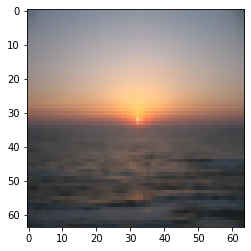

In [51]:
index = 35
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print (classes[int(d["Y_prediction_test"][0,index])])

b'cat'


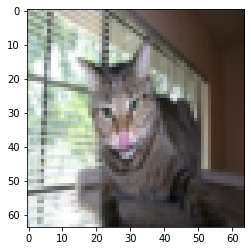

In [52]:
index = 20
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print (classes[int(d["Y_prediction_test"][0,index])])

# 6-) Öğrenme oranı

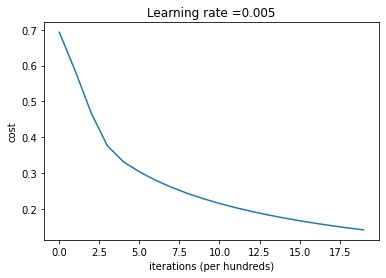

In [54]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



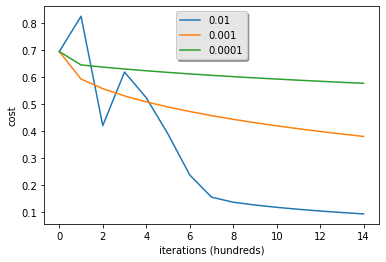

In [56]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()